In [1]:
# packager needed to run
#!conda install -c anaconda pandas -y
#!conda install -c conda-forge matplotlib -y
#!conda install -c anaconda scikit-learn -y

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import preprocessing

In [3]:
def get_na(df):
    qsna=df.shape[0]-df.isnull().sum(axis=0)
    qna=df.isnull().sum(axis=0)
    ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
    aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
    na=pd.DataFrame(data=aux)
    return na.sort_values(by='Na en %',ascending=False)

In [4]:
# cargamos los datos
tp = pd.read_csv("data/test_projects.csv")
tr = pd.read_csv("data/test_rules.csv")
tt = pd.read_csv("data/test_transactions.csv")
catalog = pd.read_csv("data/catalog.csv")

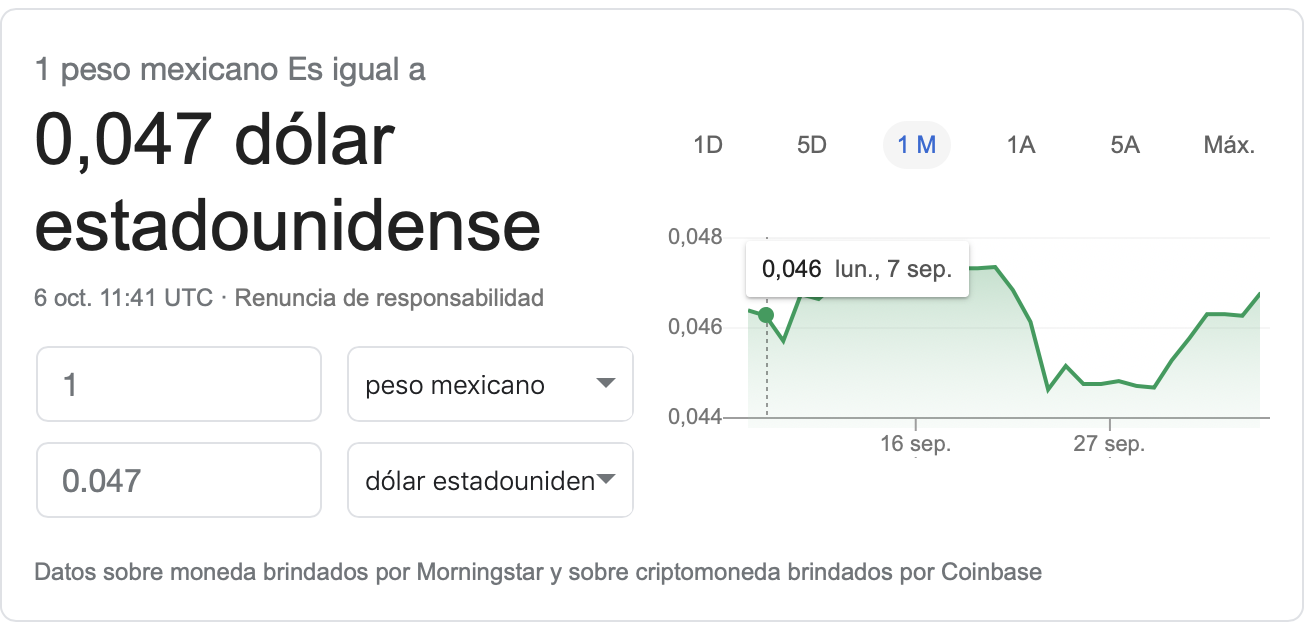

In [5]:
# hago los cambios de formato que requiero y luego me aseguro de no dejar valores NA de arrastre en la conversión
# Puedo validar que hay 40245 proyectos agregados en enero 2020
tp['goal_date']=tp.goal_date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))
zero_day=datetime.strptime('2020-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
#calculo la duración del proyecto en días
tp['project_duration'] = tp.goal_date.apply(lambda x: (x-zero_day).days)
# convierto los pesos MX a USD
tp['total']=tp['total'].apply(lambda x: float(x)*0.047).copy()
tp['total_avg']=tp['total']/tp['project_duration']
get_na(tp)

,datos sin NAs en q,Na en q,Na en %
project_id,40245,0,0.0
name,40245,0,0.0
goal_date,40245,0,0.0
user_id,40245,0,0.0
project_category_id,40245,0,0.0
total,40245,0,0.0
project_duration,40245,0,0.0
total_avg,40245,0,0.0


In [6]:
# cargo el catálogo para hacer el merge con la tabla de proyectos y asignarle el nombre de la categoría de proyecto a cada proyecto
print(catalog.head(2))
get_na(catalog)

                                 id          name                type
0  015981e401af4887becbec5f45c3cd4c      Vehiculo  project_categories
1  4500593565e942d9876fa73734336157  Solo ahorrar  project_categories


,datos sin NAs en q,Na en q,Na en %
id,22,0,0.0
name,22,0,0.0
type,22,0,0.0


In [7]:
# agreguemos el nombre de las categorías de proyecto a la tabla proyectos
tp=pd.merge(tp,catalog[['id','name']],left_on='project_category_id',right_on='id',how='inner',suffixes=('_project','_category'))
del tp['id']
del tp['project_category_id']
# hay 40245 proyectos creados, cuyo objetivo está propuesto ser alcanzado entre el 02-02-2020 y el 03-01-2038
print(min(tp.goal_date))
print(max(tp.goal_date))
print(tp.dtypes)
print(tp.shape)
tp.head(2)

2020-01-02 00:00:00
2038-01-03 00:00:00
project_id                  object
name_project                object
goal_date           datetime64[ns]
user_id                     object
total                      float64
project_duration             int64
total_avg                  float64
name_category               object
dtype: object
(40245, 8)


,project_id,name_project,goal_date,user_id,total,project_duration,total_avg,name_category
0,7593859139ff4b00b09c6a5c2d7d4602,Hogar,2020-06-02,700b1ad8bcb948d2b948c20d8e4160cd,235.0,153,1.535948,Hogar
1,529babc3deca4b3b9d7e67a3bc6b5b3e,Hogar,2020-04-09,303b4174205a4093a8c504944a95155f,470.0,99,4.747475,Hogar


In [8]:
# importante notar que hay 10467 nombres de proyectos distintos en los 40245 proyectos creados
print(len(tp.name_project.unique()))
print(tp.name_project.unique())
# importante notar que hay 10467 nombres de proyectos distintos en los 40245 proyectos creados
print(len(tp.name_category.unique()))
print(tp.name_category.unique())
tp.groupby(['name_category'])['user_id'].nunique()

10467
['Hogar' 'Comprar algo' 'Viaje' ... 'Graduación  Luis'
 'Videojuego y figura' 'Cédula profesional ']
7
['Hogar' 'Solo ahorrar' 'Comprar algo' 'Viajar' 'Vehiculo' 'Deudas' 'Otro']


name_category
Comprar algo     3364
Deudas           2531
Hogar            2137
Otro             1514
Solo ahorrar    18547
Vehiculo         3972
Viajar           5823
Name: user_id, dtype: int64

count    4.024500e+04
mean     3.059475e+06
std      3.484696e+08
min      4.700000e-02
25%      3.290000e+02
50%      7.050000e+02
75%      1.410000e+03
max      4.700000e+10
Name: total, dtype: float64


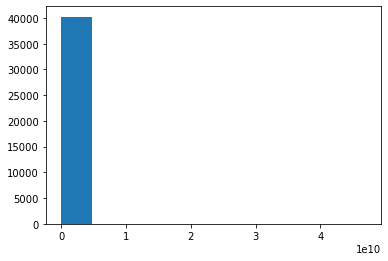

In [9]:
# los montos totales meta de los proyectos van entre 0.047usd y 47.000 millones de USD, lo cual sugiere que hay datos que no son reales en los montos
# y deben ser revisados vía análisis de outlier
# Si miro el 50% central de los datos, las metas van entre los 329 USD y los 1410 USD
print(tp.total.describe())
plt.hist(tp.total)
plt.show()

161633.00000009986
(7, 8)


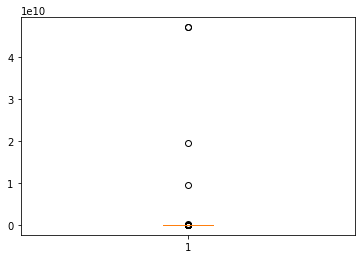

In [10]:
# podemos ver que el percentile 99.95% es en 161633 USD y que solo tenemos 7 valores sobre 1M USD
# Estos outlie suben considerablemente el promedio
print(tp.total.quantile(q=0.9995))
print(tp[tp.total>1000000].shape)
plt.boxplot(tp.total)
plt.show()

430.71926477738646
(14, 8)
(16, 8)
count    4.024500e+04
mean     8.391849e+03
std      8.631605e+05
min      8.785047e-04
25%      1.100703e+00
50%      2.282857e+00
75%      3.983051e+00
max      1.010753e+08
Name: total_avg, dtype: float64


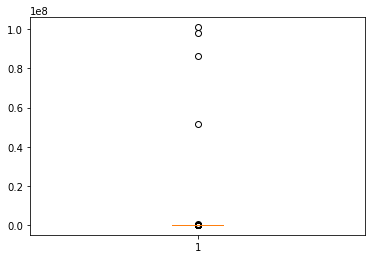

In [11]:
# podemos ver que solo tenemos 7 personas que tendrían que ahorra más de 1000 USD diarios para cumplir la meta, y 9 más de 500 USD
print(tp.total_avg.quantile(q=0.9995))
print(tp[tp.total_avg>1000].shape)
print(tp[tp.total_avg>500].shape)
print(tp.total_avg.describe())
plt.boxplot(tp.total_avg)
plt.show()

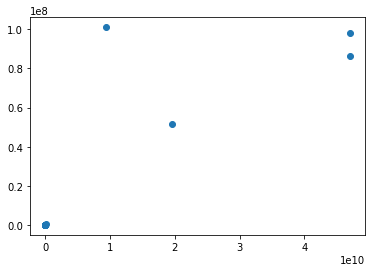

In [12]:
plt.scatter(tp.total,tp.total_avg)
plt.show()

In [13]:
# generamos un dataset especial con los "super ahorradores" para tenerlos en consideración solo al final, pues su meta de ahorro es poco representativa
# de la muestra por la cantidad de dinero diario que tendrían que juntar y nos sirve para hacer asociaciones usando métricas agregadas, 
# pues la mayoría no tendrá esa capacidad de ahorro (y poder adquisitivo)
super_ahorradores=tp[tp.total_avg>500].copy()
tp=tp[tp.total_avg<=500].copy()
super_ahorradores

,project_id,name_project,goal_date,user_id,total,project_duration,total_avg,name_category
1111,00cd849982e54119aaa3229e366bb698,Hogar,2020-02-07,7fec7fee8ec64d4d90b1abb74d8de73a,9.400000e+04,37,2.540541e+03,Hogar
1611,18354ad0379d4e79ac8190962fab8682,Averanda,2020-04-20,abea02180b354a93bd5a77be7917ac8b,2.115000e+05,110,1.922727e+03,Hogar
1759,0c25e44e078a4015becea29b8f2f0cd3,Hogar,2021-01-18,224051841a684edda05d8a6ec2347407,6.815000e+05,383,1.779373e+03,Hogar
3146,d17d7c674c1544df9cabb9a15df527f6,Guardadito,2020-01-27,6ffd5d5be1394b19b1ea959d08c5e159,2.350000e+04,26,9.038462e+02,Solo ahorrar
6068,d2060cd8b54e4a1d8f6ff3f6228925a3,Viaje,2020-11-30,89cdc13ff9484c7a966e202aae932823,3.760000e+05,334,1.125749e+03,Solo ahorrar
7142,b70f50a89f3443839a349afbfdf7c200,Fuente De Abundancia de KVRA,2021-01-01,f573bc9d8c19459db63e94d1b2ca6427,4.173600e+06,366,1.140328e+04,Solo ahorrar
9224,a24129546f5d464b8b7fd89e84b55a63,Solo guardar,2020-04-03,c65479d582fd4be39ee2ad878276fe54,9.400000e+09,93,1.010753e+08,Solo ahorrar
10640,15eb86aa438e4026ad2c607c5cfc8498,Solo guardar,2020-01-14,6c51f245df264d5ead326b61b6c91b71,1.316000e+04,13,1.012308e+03,Solo ahorrar
18344,244c43e17cae4e9aa9f42fc14558cb28,Hogar,2021-01-18,5b6c87f303184a33be235928cf5db992,2.350000e+05,383,6.135770e+02,Solo ahorrar
19765,5429eadfa5a641b4a4adf043e97a1157,Solo guardar,2021-01-22,f4cadf8e58054418ac560ca3afc42855,4.700000e+06,387,1.214470e+04,Solo ahorrar


### En futuras iteraciones:
es interesante analizar los nombres de proyectos en el futuro para corregir las categorías posteriormente. Por ejemplo: en la fila 6068 tenemos un proyecto que es de viaje pero identificó la categoría como "solo ahorrar", lo cual es incorrecto. lo mismo pasó en 18344 que era para una casa, por lo que debería ser hogar

In [14]:
# creo la tabla de usuario
user_ids=list(tp.user_id.unique())
user = pd.DataFrame({'user_id':user_ids})

# Y luego le agrego los features asociados a proyecto

# la cantidad de proyectos que tiene el usuario
aux = tp.groupby('user_id')['project_id'].count()
user['number_projects'] = user['user_id'].map(aux)

# la media del monto total del proyecto
aux = tp.groupby('user_id')['total'].mean()
user['total_mean'] = user['user_id'].map(aux)

# la mediana del monto total del proyecto
aux = tp.groupby('user_id')['total'].median()
user['total_median'] = user['user_id'].map(aux)

# la media del monto total del proyecto
aux = tp.groupby('user_id')['total_avg'].mean()
user['total_avg_mean'] = user['user_id'].map(aux)
# la mediana del monto total del proyecto
aux = tp.groupby('user_id')['total_avg'].median()
user['total_avg_median'] = user['user_id'].map(aux)

# creo el vector con las categorías de los proyectos y el número de categorías que tiene asociado el usuario
aux = tp.groupby(['user_id','name_category'])['project_id'].count()
aux = pd.DataFrame(aux).reset_index().copy()
categories = []
for i in user_ids:
    categories.append(aux[aux.user_id==i].name_category.unique())
user['categories'] = categories
user['number_categories'] = user.categories.apply(lambda x: len(x))
aux = tp.groupby('user_id')['project_duration'].sum()
user['project_duration'] = user['user_id'].map(aux)
aux = tp.groupby('user_id')['project_duration'].max()
user['max_project_duration'] = user['user_id'].map(aux)
aux = tp.groupby('user_id')['project_duration'].min()
user['min_project_duration'] = user['user_id'].map(aux)
user['mean_project_duration'] = round(user.project_duration / user.number_projects,1)

In [15]:
get_na(user)

,datos sin NAs en q,Na en q,Na en %
user_id,35489,0,0.0
number_projects,35489,0,0.0
total_mean,35489,0,0.0
total_median,35489,0,0.0
total_avg_mean,35489,0,0.0
total_avg_median,35489,0,0.0
categories,35489,0,0.0
number_categories,35489,0,0.0
project_duration,35489,0,0.0
max_project_duration,35489,0,0.0


In [16]:
print(len(categories))
print(user.shape)
user.sort_values(by='number_projects', ascending=False).head(2)

35489
(35489, 12)


,user_id,number_projects,total_mean,total_median,total_avg_mean,total_avg_median,categories,number_categories,project_duration,max_project_duration,min_project_duration,mean_project_duration
4613,a52237b4b82e4e2490bc79c9dfd2964d,19,312.921053,329.0,0.910889,0.906336,"[Comprar algo, Solo ahorrar, Viajar]",3,6536,365,151,344.0
5862,3d3e220773434d53915238f1939965a3,14,1474.457143,728.5,4.237123,2.305388,"[Comprar algo, Deudas, Solo ahorrar, Viajar]",4,5293,939,243,378.1


In [17]:
print(len(categories))
print(user.shape)
user.sort_values(by='number_categories', ascending=False).head(2)

35489
(35489, 12)


,user_id,number_projects,total_mean,total_median,total_avg_mean,total_avg_median,categories,number_categories,project_duration,max_project_duration,min_project_duration,mean_project_duration
4966,0c745586b42a47129a7d2876e3d22a49,5,526.400000,282.0,2.069757,1.528455,"[Comprar algo, Deudas, Solo ahorrar, Vehiculo,...",5,1020,367,46,204.0
587,384de600d58b42ddb5a43d3083f51366,6,626.666667,470.0,0.903734,0.311878,"[Comprar algo, Hogar, Solo ahorrar, Vehiculo, ...",5,7900,1507,365,1316.7


In [18]:
user.describe()

,number_projects,total_mean,total_median,total_avg_mean,total_avg_median,number_categories,project_duration,max_project_duration,min_project_duration,mean_project_duration
count,35489.000000,35489.000000,35489.00000,35489.000000,35489.000000,35489.000000,35489.000000,35489.000000,35489.000000,35489.000000
mean,1.133563,1503.203168,1497.14780,4.363242,4.348419,1.067148,498.103666,457.287188,426.508975,440.791473
std,0.537610,5647.844590,5644.90477,12.017696,12.008198,0.304154,655.879864,551.377028,503.375852,512.975656
min,1.000000,0.094000,0.04700,0.000879,0.000879,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,376.000000,364.25000,1.171486,1.162088,1.000000,246.000000,242.000000,216.000000,233.000000
50%,1.000000,799.000000,799.00000,2.361520,2.350000,1.000000,364.000000,361.000000,356.000000,359.000000
75%,1.000000,1410.000000,1410.00000,4.017094,4.003407,1.000000,486.000000,450.000000,399.000000,428.000000
max,19.000000,470000.000000,470000.00000,494.752028,494.752028,5.000000,17504.000000,6577.000000,6577.000000,6577.000000


count    35489.000000
mean         1.133563
std          0.537610
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         19.000000
Name: number_projects, dtype: float64


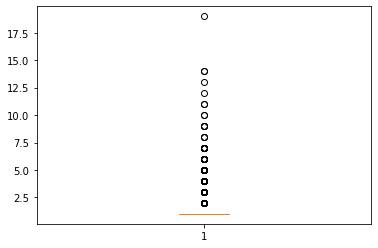

In [19]:
print(user.number_projects.describe())
plt.boxplot(user.number_projects)
plt.show()

count     35489.000000
mean       1503.203168
std        5647.844590
min           0.094000
25%         376.000000
50%         799.000000
75%        1410.000000
max      470000.000000
Name: total_mean, dtype: float64


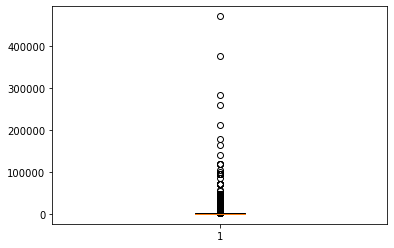

In [20]:
print(user.total_mean.describe())
plt.boxplot(user.total_mean)
plt.show()

In [21]:
print(user.groupby('number_projects')['total_mean'].describe())

                   count         mean          std          min          25%  \
number_projects                                                                
1                32351.0  1517.263147  5602.482567     0.094000   376.000000   
2                 2219.0  1414.332831  7069.668386     4.700000   350.150000   
3                  553.0  1140.014785  1723.831477     0.658000   329.000000   
4                  210.0  1539.883429  4085.596610     9.705500   353.087500   
5                   90.0  1132.994814  2062.617017    40.702000   336.050000   
6                   33.0   969.192697  1237.468079    57.183333   292.966667   
7                   17.0  1152.885611  1912.035383    21.586429   256.485714   
8                    3.0  1683.547285  1717.313451   652.616855   692.320928   
9                    4.0   768.604056   436.522016   210.445111   577.131278   
10                   2.0  1253.814300   131.400663  1160.900000  1207.357150   
11                   2.0   860.092202   

count     35489.00000
mean       1497.14780
std        5644.90477
min           0.04700
25%         364.25000
50%         799.00000
75%        1410.00000
max      470000.00000
Name: total_median, dtype: float64


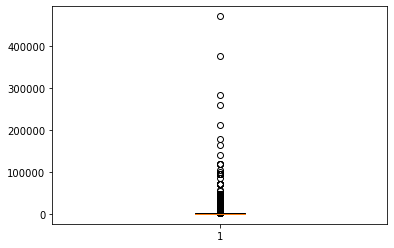

In [22]:
print(user.total_median.describe())
plt.boxplot(user.total_median)
plt.show()

In [23]:
print(user.groupby('number_projects')['total_median'].describe())

                   count         mean          std        min         25%  \
number_projects                                                             
1                32351.0  1517.263147  5602.482567    0.09400  376.000000   
2                 2219.0  1414.332831  7069.668386    4.70000  350.150000   
3                  553.0   939.423768  1483.150269    0.04700  235.000000   
4                  210.0  1221.141800  3477.319857    9.70550  258.500000   
5                   90.0   864.536539  2252.703217   25.85000  235.000000   
6                   33.0   813.929621  1134.576864   23.50000  235.000000   
7                   17.0   975.786353  1767.606900    9.40000  230.300000   
8                    3.0  1335.583333  1224.840049  599.25000  628.625000   
9                    4.0   599.250000   413.537685   70.50000  370.125000   
10                   2.0   574.880500   516.356949  209.76100  392.320750   
11                   2.0   778.848045   227.903280  617.69609  698.272068   

count    35489.000000
mean         1.133563
std          0.537610
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         19.000000
Name: number_projects, dtype: float64


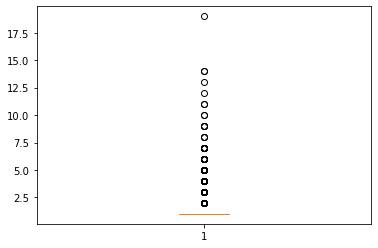

In [24]:
print(user.number_projects.describe())
plt.boxplot(user.number_projects)
plt.show()

In [25]:
user.corr()

,number_projects,total_mean,total_median,total_avg_mean,total_avg_median,number_categories,project_duration,max_project_duration,min_project_duration,mean_project_duration
number_projects,1.000000,-0.008532,-0.013911,-0.011582,-0.018146,0.771639,0.332544,0.091909,-0.087333,-0.005660
total_mean,-0.008532,1.000000,0.999287,0.566469,0.566174,-0.007916,0.127416,0.140378,0.147733,0.147748
total_median,-0.013911,0.999287,1.000000,0.565884,0.566351,-0.013748,0.124671,0.138654,0.148336,0.147490
total_avg_mean,-0.011582,0.566469,0.565884,1.000000,0.999472,-0.009147,-0.058778,-0.064288,-0.064676,-0.066041
total_avg_median,-0.018146,0.566174,0.566351,0.999472,1.000000,-0.016119,-0.060673,-0.064876,-0.063990,-0.065944
number_categories,0.771639,-0.007916,-0.013748,-0.009147,-0.016119,1.000000,0.267674,0.089748,-0.079753,-0.001035
project_duration,0.332544,0.127416,0.124671,-0.058778,-0.060673,0.267674,1.000000,0.928129,0.774208,0.868826
max_project_duration,0.091909,0.140378,0.138654,-0.064288,-0.064876,0.089748,0.928129,1.000000,0.904845,0.971494
min_project_duration,-0.087333,0.147733,0.148336,-0.064676,-0.063990,-0.079753,0.774208,0.904845,1.000000,0.977844
mean_project_duration,-0.005660,0.147748,0.147490,-0.066041,-0.065944,-0.001035,0.868826,0.971494,0.977844,1.000000


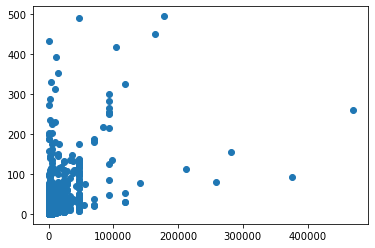

In [26]:
plt.scatter(user.total_median,user.total_avg_median)
plt.show()

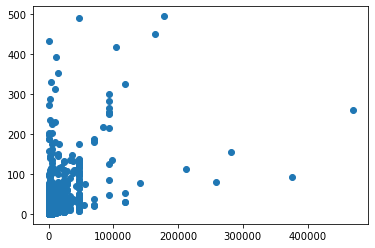

In [27]:
plt.scatter(user.total_mean,user.total_avg_mean)
plt.show()

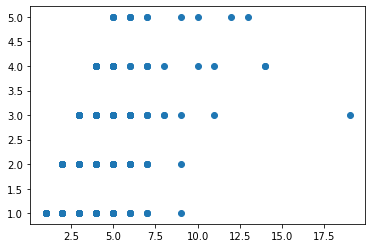

In [28]:
plt.scatter(user.number_projects,user.number_categories)
plt.show()

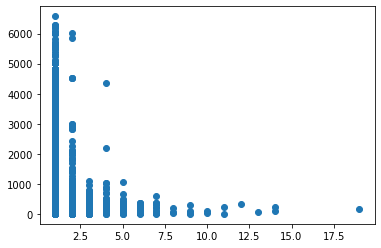

In [29]:
plt.scatter(user.number_projects,user.min_project_duration)
plt.show()

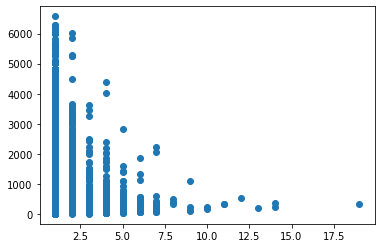

In [30]:
plt.scatter(user.number_projects,user.mean_project_duration)
plt.show()

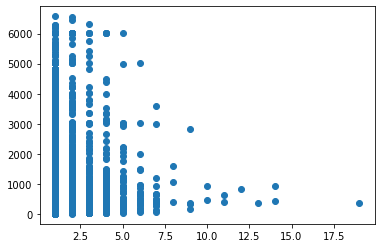

In [31]:
plt.scatter(user.number_projects,user.max_project_duration)
plt.show()

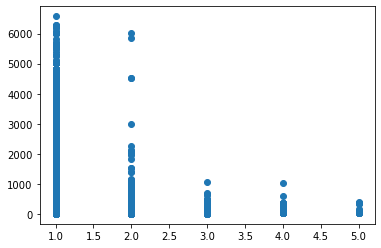

In [32]:
plt.scatter(user.number_categories,user.min_project_duration)
plt.show()

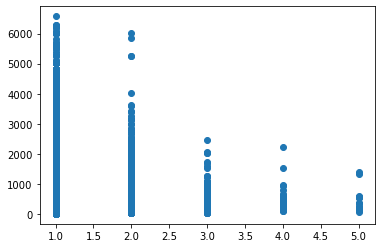

In [33]:
plt.scatter(user.number_categories,user.mean_project_duration)
plt.show()

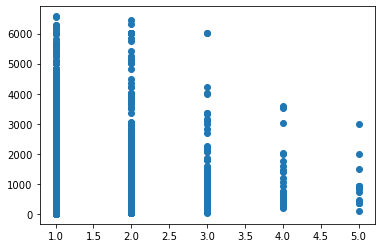

In [34]:
plt.scatter(user.number_categories,user.max_project_duration)
plt.show()

### Ahora le agregamos los datos de las reglas con las métricas por proyecto

In [35]:
print(tr.dtypes)
print(tr.frecuency.unique())
tr.head(2)

rule_id          object
project_id       object
rule_type_id     object
amount          float64
frecuency         int64
categories       object
dtype: object
[ 0  7 15  1 30  2  3]


,rule_id,project_id,rule_type_id,amount,frecuency,categories
0,2f206c2f263f4332aa8985dbe25fc0b5,7593859139ff4b00b09c6a5c2d7d4602,c175e7bf6cf64677903bac9389a80cd9,10.0,0,NaN
1,7cffbe8d84534f489637b0ab8694f234,7593859139ff4b00b09c6a5c2d7d4602,b30b058a53634cbcb1f589af13e6689f,228.0,7,NaN


In [36]:
# importante notar que las categorías de las reglas tienen un 91.4% de NA'S. Por lo tanto, no usaremos esa columna inicialmente 
# y la dejaremos para ser investigada en una segunda iteración
# convierto los pesos MX a USD y calcúlo el monto máximo de ahorro posible para aquellos que tienen reglas de X monto,Y veces por mes
get_na(tr)

,datos sin NAs en q,Na en q,Na en %
categories,5641,62613,91.74
rule_id,68254,0,0.00
project_id,68254,0,0.00
rule_type_id,68254,0,0.00
amount,68254,0,0.00
frecuency,68254,0,0.00


In [37]:
# agreguemos el nombre de las categorías de proyecto a la tabla proyectos
tr=pd.merge(tr.drop('categories',axis=1),catalog[['id','name']],left_on='rule_type_id',right_on='id',how='inner',suffixes=('_rules','_category')).drop(['rule_type_id','id'], axis=1)
tr.sort_values(by='frecuency', ascending=False).head(5)

,rule_id,project_id,amount,frecuency,name
10999,8bb7571402cd4192a652aaf299832728,c601da20073941139bfa643c51cb0a4f,1500.0,30,Monto fijo
13425,c935d08710424d7b98fd1e34981ebef8,fe37708e2a7241a1bd53e86ca65617e7,1250.0,30,Monto fijo
19310,0386ed8774b042b5ad924a989c7d843b,898e7ac494844bf1b26a48fe2f789351,1500.0,30,Monto fijo
15842,08c74d1153054a00a3cc77a28d4f5755,9dd28b23d59f409e8776f3c7c067fda9,500.0,30,Monto fijo
33199,272e80ca55ac4049a7293c3a166f617f,3da55e766a704d2686c7607d54d5f1eb,1819.0,30,Monto fijo


In [38]:
print(tr.name.unique())
print(tr.groupby('name')['frecuency'].describe())

['Redondear' 'Monto fijo' 'Placer culpable' '% de mi sueldo'
 'Desafío 52 semanas' 'Santander TAP' 'Pasión Futbolera']
                      count       mean       std  min  25%  50%   75%   max
name                                                                       
% de mi sueldo      11807.0   0.000000  0.000000  0.0  0.0  0.0   0.0   0.0
Desafío 52 semanas  10321.0   0.000000  0.000000  0.0  0.0  0.0   0.0   0.0
Monto fijo          28487.0  11.148419  8.372163  1.0  7.0  7.0  15.0  30.0
Pasión Futbolera       51.0   2.000000  0.916515  1.0  1.0  2.0   3.0   3.0
Placer culpable      5591.0   0.000000  0.000000  0.0  0.0  0.0   0.0   0.0
Redondear           10511.0   0.000000  0.000000  0.0  0.0  0.0   0.0   0.0
Santander TAP        1486.0   0.000000  0.000000  0.0  0.0  0.0   0.0   0.0


### Normalización de los montos

Considerando que los montos dependen del tipo de regla, vamos a normalizar los montos en valores de 0 a 1, de tal forma que el 1 es el valor máximo y el 0 el valor mínimo. De esta forma, la distribución de las variables se mantiene pero podremos comparar entre distintas categorías de reglas, entendiendo que estamos comparando el valor relativo del monto.

Link a la refeencia: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html#sklearn.preprocessing.Normalizer

            amount  frecuency
count  1486.000000     1486.0
mean      9.273217        0.0
std       4.172305        0.0
min       1.000000        0.0
25%      10.000000        0.0
50%      10.000000        0.0
75%      10.000000        0.0
max      20.000000        0.0


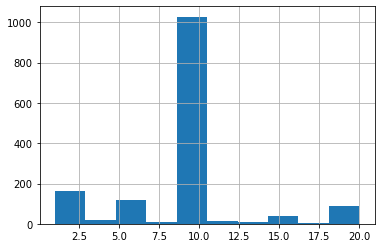

In [39]:
print(tr[tr.name=='Santander TAP'].describe())
tr[tr.name=='Santander TAP'].amount.hist();

<ipython-input-40-7fc67739ff9a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux0['scaled']=normalizer.fit_transform(aux0.amount.values.reshape(1, -1))[0]
/opt/miniconda3/envs/ubank/lib/python3.8/site-packages/pandas/core/frame.py:4160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


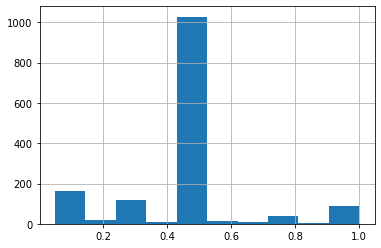

In [40]:
aux0=tr[tr.name=='Santander TAP']
normalizer = preprocessing.Normalizer(norm='max') 
aux0['scaled']=normalizer.fit_transform(aux0.amount.values.reshape(1, -1))[0]
aux0.drop(['amount','frecuency'],axis=1,inplace=True)
aux0.scaled.hist();

           amount  frecuency
count   51.000000  51.000000
mean    78.803922   2.000000
std     82.514004   0.916515
min      4.000000   1.000000
25%     50.000000   1.000000
50%     50.000000   2.000000
75%    100.000000   3.000000
max    500.000000   3.000000


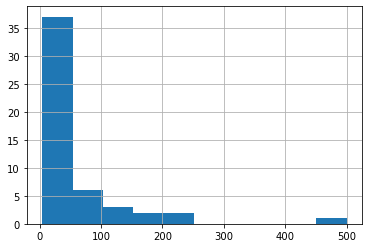

In [41]:
print(tr[tr.name=='Pasión Futbolera'].describe())
tr[tr.name=='Pasión Futbolera'].amount.hist();

# eliminar pasión futbolera

<ipython-input-42-ac92c951efe1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['mean_amount']=aux1.amount/aux1.frecuency
<ipython-input-42-ac92c951efe1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['scaled']=normalizer.fit_transform(aux1.mean_amount.values.reshape(1, -1))[0]
/opt/miniconda3/envs/ubank/lib/python3.8/site-packages/pandas/core/frame.py:4160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

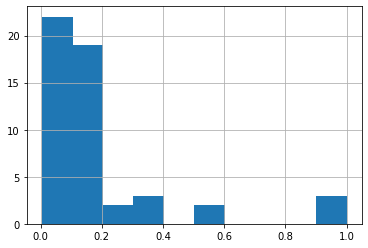

In [42]:
aux1=tr[tr.name=='Pasión Futbolera']
aux1['mean_amount']=aux1.amount/aux1.frecuency
normalizer = preprocessing.Normalizer(norm='max') 
aux1['scaled']=normalizer.fit_transform(aux1.mean_amount.values.reshape(1, -1))[0]
aux1.drop(['mean_amount','amount','frecuency'],axis=1,inplace=True)
aux1.scaled.hist();

             amount  frecuency
count   5591.000000     5591.0
mean      39.763613        0.0
std      562.668827        0.0
min        1.000000        0.0
25%       20.000000        0.0
50%       20.000000        0.0
75%       20.000000        0.0
max    28000.000000        0.0


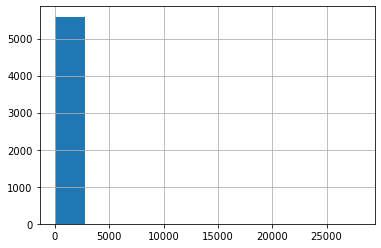

In [43]:
print(tr[tr.name=='Placer culpable'].describe())
tr[tr.name=='Placer culpable'].amount.hist();

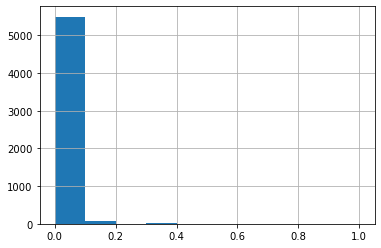

In [44]:
aux2=tr[tr.name=='Placer culpable']
# elimino los 3 registros que están sobre los 1500 pesos MX (69 usd) para normalizar, de tal forma que no me distorcionen la métrica del tamaño
# luego les imputaré el valor máximo que es un 1 
aux2=aux2[aux2.amount<=1500]
normalizer = preprocessing.Normalizer(norm='max') 
aux2['scaled']=normalizer.fit_transform(aux2.amount.values.reshape(1, -1))[0]
aux2.drop(['amount','frecuency'],axis=1,inplace=True)
aux2.scaled.hist();

In [45]:
# les dejo el valor 1 , que es el máximo
aux3=tr[tr.name=='Placer culpable']
# elimino los 3 registros que están sobre los 1500 pesos MX (69 usd)
aux3=aux3[aux3.amount>1500]
aux3.drop(['amount','frecuency'],axis=1,inplace=True)
aux3['scaled']=1

             amount  frecuency
count  11807.000000    11807.0
mean      12.716778        0.0
std       11.657854        0.0
min        1.000000        0.0
25%        5.000000        0.0
50%       10.000000        0.0
75%       15.000000        0.0
max       50.000000        0.0


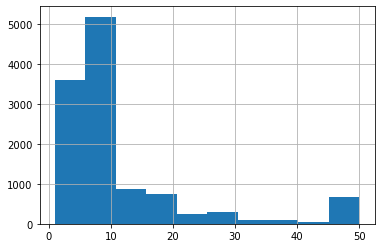

In [46]:
print(tr[tr.name=='% de mi sueldo'].describe())
tr[tr.name=='% de mi sueldo'].amount.hist();

<ipython-input-47-d5c5546f8103>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux4['scaled']=normalizer.fit_transform(aux4.amount.values.reshape(1, -1))[0]
/opt/miniconda3/envs/ubank/lib/python3.8/site-packages/pandas/core/frame.py:4160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


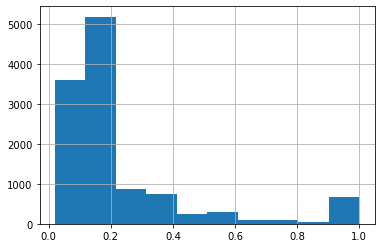

In [47]:
aux4=tr[tr.name=='% de mi sueldo']
normalizer = preprocessing.Normalizer(norm='max') 
aux4['scaled']=normalizer.fit_transform(aux4.amount.values.reshape(1, -1))[0]
aux4.drop(['amount','frecuency'],axis=1,inplace=True)
aux4.scaled.hist();

             amount     frecuency
count  2.848700e+04  28487.000000
mean   1.131388e+03     11.148419
std    1.228691e+04      8.372163
min    0.000000e+00      1.000000
25%    1.140000e+02      7.000000
50%    3.600000e+02      7.000000
75%    9.620000e+02     15.000000
max    1.687500e+06     30.000000


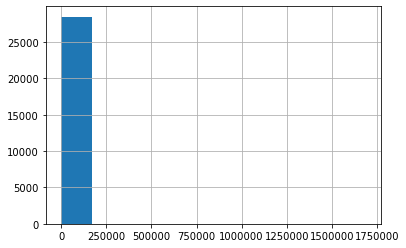

In [48]:
print(tr[tr.name=='Monto fijo'].describe())
tr[tr.name=='Monto fijo'].amount.hist();

count     28487.000000
mean        143.153466
std        1641.223769
min           0.000000
25%          21.000000
50%          43.533333
75%          87.000000
max      115000.000000
Name: mean_amount, dtype: float64


<ipython-input-49-a7fee2d2be9c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux5['mean_amount']=aux5.amount/aux5.frecuency


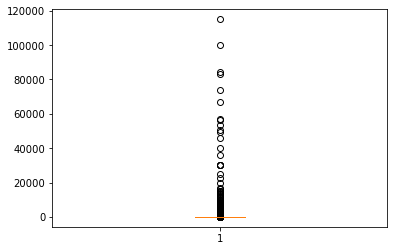

In [49]:
aux5=tr[tr.name=='Monto fijo']
aux5['mean_amount']=aux5.amount/aux5.frecuency
print(aux5.mean_amount.describe())
plt.boxplot(aux5['mean_amount'])
plt.show();

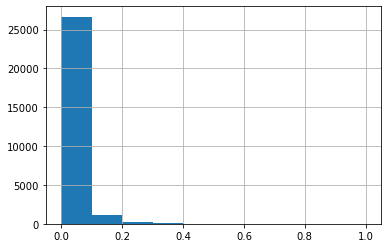

In [50]:
# sacamos los outlier superiores correspondientes al 1% de la muestra para normalizar y les asignamos un valor de 1
aux6=aux5[aux5.mean_amount>1000]
aux5=aux5[aux5.mean_amount<=1000]
normalizer = preprocessing.Normalizer(norm='max') 
aux5['scaled']=normalizer.fit_transform(aux5.amount.values.reshape(1, -1))[0]
aux5.drop(['mean_amount','amount','frecuency'],axis=1,inplace=True)
aux5.scaled.hist();

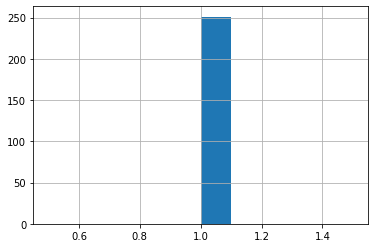

In [51]:
normalizer = preprocessing.Normalizer(norm='max') 
aux6['scaled']=1
aux6.drop(['mean_amount','amount','frecuency'],axis=1,inplace=True)
aux6.scaled.hist();

             amount  frecuency
count  10511.000000    10511.0
mean       9.764532        0.0
std        1.059245        0.0
min        5.000000        0.0
25%       10.000000        0.0
50%       10.000000        0.0
75%       10.000000        0.0
max       10.000000        0.0


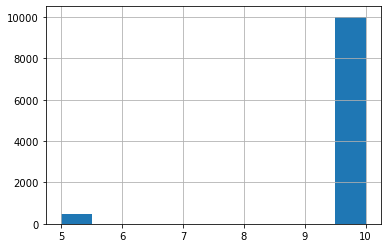

In [52]:
print(tr[tr.name=='Redondear'].describe())
tr[tr.name=='Redondear'].amount.hist();

<ipython-input-53-e26b82d1b67c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux7['scaled']=normalizer.fit_transform(aux7.amount.values.reshape(1, -1))[0]
/opt/miniconda3/envs/ubank/lib/python3.8/site-packages/pandas/core/frame.py:4160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


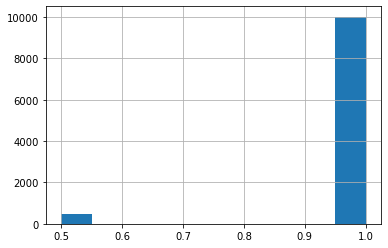

In [53]:
aux7=tr[tr.name=='Redondear']
normalizer = preprocessing.Normalizer(norm='max') 
aux7['scaled']=normalizer.fit_transform(aux7.amount.values.reshape(1, -1))[0]
aux7.drop(['amount','frecuency'],axis=1,inplace=True)
aux7.scaled.hist();

             amount  frecuency
count  10321.000000    10321.0
mean       5.259180        0.0
std        1.108533        0.0
min        5.000000        0.0
25%        5.000000        0.0
50%        5.000000        0.0
75%        5.000000        0.0
max       10.000000        0.0


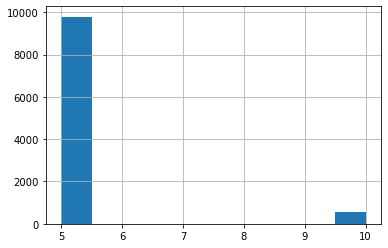

In [54]:
print(tr[tr.name=='Desafío 52 semanas'].describe())
tr[tr.name=='Desafío 52 semanas'].amount.hist();

<ipython-input-55-d5cca220ced0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux8['scaled']=normalizer.fit_transform(aux8.amount.values.reshape(1, -1))[0]
/opt/miniconda3/envs/ubank/lib/python3.8/site-packages/pandas/core/frame.py:4160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


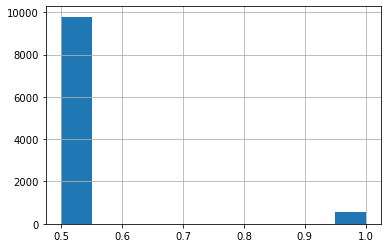

In [55]:
aux8=tr[tr.name=='Desafío 52 semanas']
normalizer = preprocessing.Normalizer(norm='max') 
aux8['scaled']=normalizer.fit_transform(aux8.amount.values.reshape(1, -1))[0]
aux8.drop(['amount','frecuency'],axis=1,inplace=True)
aux8.scaled.hist();

             scaled
count  68254.000000
mean       0.300901
std        0.365248
min        0.000000
25%        0.013333
50%        0.100000
75%        0.500000
max        1.000000


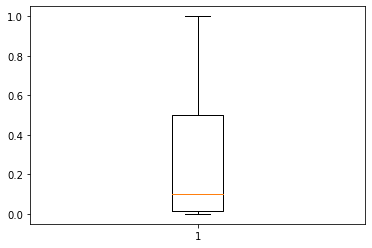

In [56]:
aux=pd.concat([aux0,aux1,aux2,aux3,aux4,aux5,aux6,aux7,aux8]).copy()
print(aux.describe())
plt.boxplot(aux.scaled)
plt.show()

In [57]:
# agreguemos el nombre de las categorías de proyecto a la tabla proyectos
tr=pd.merge(tr,aux[['rule_id','scaled']],left_on='rule_id',right_on='rule_id',how='inner',suffixes=('_rules','_scaled')).copy()
tr.sort_values(by='frecuency', ascending=False).head(5)

,rule_id,project_id,amount,frecuency,name,scaled
10999,8bb7571402cd4192a652aaf299832728,c601da20073941139bfa643c51cb0a4f,1500.0,30,Monto fijo,0.050000
13425,c935d08710424d7b98fd1e34981ebef8,fe37708e2a7241a1bd53e86ca65617e7,1250.0,30,Monto fijo,0.041667
19310,0386ed8774b042b5ad924a989c7d843b,898e7ac494844bf1b26a48fe2f789351,1500.0,30,Monto fijo,0.050000
15842,08c74d1153054a00a3cc77a28d4f5755,9dd28b23d59f409e8776f3c7c067fda9,500.0,30,Monto fijo,0.016667
33199,272e80ca55ac4049a7293c3a166f617f,3da55e766a704d2686c7607d54d5f1eb,1819.0,30,Monto fijo,0.060633


In [58]:
get_na(tr)

,datos sin NAs en q,Na en q,Na en %
rule_id,68254,0,0.0
project_id,68254,0,0.0
amount,68254,0,0.0
frecuency,68254,0,0.0
name,68254,0,0.0
scaled,68254,0,0.0


In [59]:
# la media de los montos de las reglas del proyecto
aux = tr.groupby('project_id')['scaled'].mean()
tp['ammount_mean_scaled'] = tp['project_id'].map(aux)

# la mediana de los montos de las reglas del proyecto
aux = tr.groupby('project_id')['scaled'].median()
tp['ammount_median_scaled'] = tp['project_id'].map(aux)

In [60]:
#creo el vector con lel tipo de regla y el número de categorías que tiene asociado el usuario
aux = tr.groupby(['project_id','name'])['frecuency'].count()
aux=pd.DataFrame(aux).reset_index().copy()
aux.sort_values(by='frecuency', ascending=False).head(5)

,project_id,name,frecuency
23289,5939bf2205874476bea2cefcf24c2c59,Placer culpable,8
27601,69e54cbf6d3d4d2aba33e7467ab7bf77,Placer culpable,6
32325,7bcc4e1383f24454a7ccf1b6de4a1eb4,Placer culpable,5
62553,ef2d23f2b1084c4f80d62984f3ce2876,Placer culpable,5
49206,bc89440c35544037a2dbd24361c5c476,Placer culpable,5


In [61]:
#chequeo de consistencia
# en este caso podemos ver un posible problema:existe la misma regla de placer culpabanle creada varias veces para el mismo proyecto
tr[tr.project_id=='ef2d23f2b1084c4f80d62984f3ce2876']

,rule_id,project_id,amount,frecuency,name,scaled
9046,e9aecda0c04643b9af6de8bfe3897184,ef2d23f2b1084c4f80d62984f3ce2876,10.0,0,Redondear,1.000000
43792,12e6b002d2da4098a1715ee633d10ff9,ef2d23f2b1084c4f80d62984f3ce2876,10.0,0,Placer culpable,0.006667
43793,13f209719d4646dda4672376607cfced,ef2d23f2b1084c4f80d62984f3ce2876,10.0,0,Placer culpable,0.006667
43794,5cda8d85a980495588658d8fd54d8340,ef2d23f2b1084c4f80d62984f3ce2876,10.0,0,Placer culpable,0.006667
43795,f017c1f99a5544a2918b9d84a49dc829,ef2d23f2b1084c4f80d62984f3ce2876,10.0,0,Placer culpable,0.006667
43796,f7b9e1059d414953ac038123aaa3c5ff,ef2d23f2b1084c4f80d62984f3ce2876,10.0,0,Placer culpable,0.006667
65407,7063752e0bd248c583d9db379dbeed2f,ef2d23f2b1084c4f80d62984f3ce2876,10.0,0,Desafío 52 semanas,1.000000


In [62]:
#chequeo de consistencia
tp[tp.project_id=='ef2d23f2b1084c4f80d62984f3ce2876']

,project_id,name_project,goal_date,user_id,total,project_duration,total_avg,name_category,ammount_mean_scaled,ammount_median_scaled
30769,ef2d23f2b1084c4f80d62984f3ce2876,Viaje,2020-06-14,065aff5500284d4da0440e8d7848633a,1175.0,165,7.121212,Viajar,0.290476,0.006667


In [63]:
#creo el vector con lel tipo de regla y el número de categorías que tiene asociado el usuario
projects_ids=list(tp.project_id.unique())
aux = tr.groupby(['project_id','name'])['frecuency'].count()
aux = pd.DataFrame(aux).reset_index().copy()
rules_type = []
for i in projects_ids:
    rules_type.append(list(aux[aux.project_id==i].name.unique()))

In [64]:
# test unitario: chequeo de consistencia
print(rules_type[0])
aux[aux.project_id==projects_ids[0]]

['Monto fijo', 'Redondear']


,project_id,name,frecuency
30664,7593859139ff4b00b09c6a5c2d7d4602,Monto fijo,1
30665,7593859139ff4b00b09c6a5c2d7d4602,Redondear,1


In [65]:
tp['rules_type']=None
tp.loc[tp.project_id==projects_ids,'rules_type']=rules_type
tp['number_rules'] = tp.rules_type.apply(lambda x: len(x))
tp.head(5)

/opt/miniconda3/envs/ubank/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/opt/miniconda3/envs/ubank/lib/python3.8/site-packages/pandas/core/internals/blocks.py:843: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


,project_id,name_project,goal_date,user_id,total,project_duration,total_avg,name_category,ammount_mean_scaled,ammount_median_scaled,rules_type,number_rules
0,7593859139ff4b00b09c6a5c2d7d4602,Hogar,2020-06-02,700b1ad8bcb948d2b948c20d8e4160cd,235.0,153,1.535948,Hogar,0.503800,0.503800,"[Monto fijo, Redondear]",2
1,529babc3deca4b3b9d7e67a3bc6b5b3e,Hogar,2020-04-09,303b4174205a4093a8c504944a95155f,470.0,99,4.747475,Hogar,0.233810,0.033333,"[Desafío 52 semanas, Monto fijo, Placer culpab...",4
2,0d0849af491841f5bd932d718ae949b0,Hogar,2020-12-25,adea271783204301a22de71a6ec455a4,564.0,359,1.571031,Hogar,0.508333,0.508333,"[Monto fijo, Redondear]",2
3,79bb8a7369f144238b76e00a536d6d81,Hogar,2023-02-13,67446aad42a44714ae0fdb7795e2c0f4,1222.0,1139,1.072871,Hogar,0.023333,0.023333,[Monto fijo],1
4,68bf68bc5e2d467db06b29acd8911ad4,Hogar,2021-01-05,b33792fa266d4943b372719cb1cbc9f2,47000.0,370,127.027027,Hogar,0.833333,1.000000,"[Desafío 52 semanas, Monto fijo, Redondear]",3


In [66]:
# la cantidad de reglas que tiene el usuario
aux = tp.groupby('user_id')['number_rules'].sum()
user['number_rules'] = user['user_id'].map(aux)
# la media escalada del tamaño del aporte por usuario
aux = tp.groupby('user_id')['ammount_mean_scaled'].mean().fillna(0)
user['ammount_mean_scaled'] = user['user_id'].map(aux)
# la mediana escalada del tamaño del aporte por usuario
aux = tp.groupby('user_id')['ammount_median_scaled'].median().fillna(0)
user['ammount_median_scaled'] = user['user_id'].map(aux)

In [67]:
# le aplico el one hot encoder a las reglas
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
tr["labeled_rule"] = le.fit_transform(tr.name)
encoded=pd.get_dummies(tr.name)
tr=pd.concat([tr,encoded],axis=1)
tr.head()

,rule_id,project_id,amount,frecuency,name,scaled,labeled_rule,% de mi sueldo,Desafío 52 semanas,Monto fijo,Pasión Futbolera,Placer culpable,Redondear,Santander TAP
0,2f206c2f263f4332aa8985dbe25fc0b5,7593859139ff4b00b09c6a5c2d7d4602,10.0,0,Redondear,1.0,5,0,0,0,0,0,1,0
1,66c2e3a471e14faa8e8967a1f59e86b3,0baba95b627a42dbbaa7a4d5a0d49458,10.0,0,Redondear,1.0,5,0,0,0,0,0,1,0
2,1e63dc95098d422db6437c660441c690,e867c880d61f4658b34319f6bae6a81d,10.0,0,Redondear,1.0,5,0,0,0,0,0,1,0
3,62c1d6753bf74e00b4b1ba899ce15465,aecefa472c344ee9be9e9a0072d68f9c,10.0,0,Redondear,1.0,5,0,0,0,0,0,1,0
4,b4d8151917084709b878efc409561fc1,529babc3deca4b3b9d7e67a3bc6b5b3e,10.0,0,Redondear,1.0,5,0,0,0,0,0,1,0


In [68]:
tr[tr.project_id=='7593859139ff4b00b09c6a5c2d7d4602']

,rule_id,project_id,amount,frecuency,name,scaled,labeled_rule,% de mi sueldo,Desafío 52 semanas,Monto fijo,Pasión Futbolera,Placer culpable,Redondear,Santander TAP
0,2f206c2f263f4332aa8985dbe25fc0b5,7593859139ff4b00b09c6a5c2d7d4602,10.0,0,Redondear,1.0000,5,0,0,0,0,0,1,0
10511,7cffbe8d84534f489637b0ab8694f234,7593859139ff4b00b09c6a5c2d7d4602,228.0,7,Monto fijo,0.0076,2,0,0,1,0,0,0,0


In [78]:
# regla % de mi sueldo
aux = tr.groupby(['project_id'])['% de mi sueldo'].sum()
tp['% de mi sueldo'] = tp['project_id'].map(aux).fillna(0)
# regla desafio 52 semanas
aux = tr.groupby(['project_id'])['Desafío 52 semanas'].sum()
tp['Desafío 52 semanas'] = tp['project_id'].map(aux).fillna(0)
# regla monto fijo
aux = tr.groupby(['project_id'])['Monto fijo'].sum()
tp['Monto fijo'] = tp['project_id'].map(aux).fillna(0)
# regla pasión futbolera
aux = tr.groupby(['project_id'])['Pasión Futbolera'].sum()
tp['Pasión Futbolera'] = tp['project_id'].map(aux).fillna(0)
# regla placer culpable
aux = tr.groupby(['project_id'])['Placer culpable'].sum()
tp['Placer culpable'] = tp['project_id'].map(aux).fillna(0)
# regla redondear
aux = tr.groupby(['project_id'])['Redondear'].sum()
tp['Redondear'] = tp['project_id'].map(aux).fillna(0)
# regla desafio 52 semanas
aux = tr.groupby(['project_id'])['Santander TAP'].sum()
tp['Santander TAP'] = tp['project_id'].map(aux).fillna(0)
tp.head()

,project_id,name_project,goal_date,user_id,total,project_duration,total_avg,name_category,ammount_mean_scaled,ammount_median_scaled,rules_type,number_rules,% de mi sueldo,Monto fijo,Desafío 52 semanas,Pasión Futbolera,Placer culpable,Redondear,Santander TAP
0,7593859139ff4b00b09c6a5c2d7d4602,Hogar,2020-06-02,700b1ad8bcb948d2b948c20d8e4160cd,235.0,153,1.535948,Hogar,0.503800,0.503800,"[Monto fijo, Redondear]",2,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,529babc3deca4b3b9d7e67a3bc6b5b3e,Hogar,2020-04-09,303b4174205a4093a8c504944a95155f,470.0,99,4.747475,Hogar,0.233810,0.033333,"[Desafío 52 semanas, Monto fijo, Placer culpab...",4,0.0,1.0,1.0,0.0,4.0,1.0,0.0
2,0d0849af491841f5bd932d718ae949b0,Hogar,2020-12-25,adea271783204301a22de71a6ec455a4,564.0,359,1.571031,Hogar,0.508333,0.508333,"[Monto fijo, Redondear]",2,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,79bb8a7369f144238b76e00a536d6d81,Hogar,2023-02-13,67446aad42a44714ae0fdb7795e2c0f4,1222.0,1139,1.072871,Hogar,0.023333,0.023333,[Monto fijo],1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,68bf68bc5e2d467db06b29acd8911ad4,Hogar,2021-01-05,b33792fa266d4943b372719cb1cbc9f2,47000.0,370,127.027027,Hogar,0.833333,1.000000,"[Desafío 52 semanas, Monto fijo, Redondear]",3,0.0,1.0,1.0,0.0,0.0,1.0,0.0


In [81]:
# test unitario: chequeo de consistencia del cálculo
tr[tr.project_id=='529babc3deca4b3b9d7e67a3bc6b5b3e']

,rule_id,project_id,amount,frecuency,name,scaled,labeled_rule,% de mi sueldo,Desafío 52 semanas,Monto fijo,Pasión Futbolera,Placer culpable,Redondear,Santander TAP
4,b4d8151917084709b878efc409561fc1,529babc3deca4b3b9d7e67a3bc6b5b3e,10.0,0,Redondear,1.000000,5,0,0,0,0,0,1,0
10521,5891ed8392714067b7fb1ef200b47311,529babc3deca4b3b9d7e67a3bc6b5b3e,100.0,1,Monto fijo,0.003333,2,0,0,1,0,0,0,0
39000,41e918c9f1c34b48ac039dd3aeb3832c,529babc3deca4b3b9d7e67a3bc6b5b3e,50.0,0,Placer culpable,0.033333,4,0,0,0,0,1,0,0
39001,5b88a7cfe17c4fb29587da0871cd3cfc,529babc3deca4b3b9d7e67a3bc6b5b3e,50.0,0,Placer culpable,0.033333,4,0,0,0,0,1,0,0
39002,829aff910bb74f5d865589bce634d7ff,529babc3deca4b3b9d7e67a3bc6b5b3e,50.0,0,Placer culpable,0.033333,4,0,0,0,0,1,0,0
39003,dbed39b05be54012b1a8120d5255daa9,529babc3deca4b3b9d7e67a3bc6b5b3e,50.0,0,Placer culpable,0.033333,4,0,0,0,0,1,0,0
56398,c4a7ba6cf8374a10ab58c4c043507055,529babc3deca4b3b9d7e67a3bc6b5b3e,5.0,0,Desafío 52 semanas,0.500000,1,0,1,0,0,0,0,0


In [83]:
tp.head(2)

,project_id,name_project,goal_date,user_id,total,project_duration,total_avg,name_category,ammount_mean_scaled,ammount_median_scaled,rules_type,number_rules,% de mi sueldo,Monto fijo,Desafío 52 semanas,Pasión Futbolera,Placer culpable,Redondear,Santander TAP
0,7593859139ff4b00b09c6a5c2d7d4602,Hogar,2020-06-02,700b1ad8bcb948d2b948c20d8e4160cd,235.0,153,1.535948,Hogar,0.50380,0.503800,"[Monto fijo, Redondear]",2,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,529babc3deca4b3b9d7e67a3bc6b5b3e,Hogar,2020-04-09,303b4174205a4093a8c504944a95155f,470.0,99,4.747475,Hogar,0.23381,0.033333,"[Desafío 52 semanas, Monto fijo, Placer culpab...",4,0.0,1.0,1.0,0.0,4.0,1.0,0.0


In [92]:
# regla % de mi sueldo
aux = tp.groupby('user_id')['% de mi sueldo'].sum()
user['% de mi sueldo'] = user['user_id'].map(aux)
# Monto fijo
aux = tp.groupby('user_id')['Monto fijo'].sum()
user['Monto fijo'] = user['user_id'].map(aux)
# regla Desafío 52 semanas
aux = tp.groupby('user_id')['Desafío 52 semanas'].median().fillna(0)
user['Desafío 52 semanas'] = user['user_id'].map(aux)
# Pasión Futbolera
aux = tp.groupby('user_id')['Pasión Futbolera'].median().fillna(0)
user['Pasión Futbolera'] = user['user_id'].map(aux)
# Placer culpable
aux = tp.groupby('user_id')['Placer culpable'].median().fillna(0)
user['Placer culpable'] = user['user_id'].map(aux)
# Redondear
aux = tp.groupby('user_id')['Redondear'].median().fillna(0)
user['Redondear'] = user['user_id'].map(aux)
# Redondear
aux = tp.groupby('user_id')['Santander TAP'].median().fillna(0)
user['Santander TAP'] = user['user_id'].map(aux)

In [97]:
user.head(10)

,user_id,number_projects,total_mean,total_median,total_avg_mean,total_avg_median,categories,number_categories,project_duration,max_project_duration,...,number_rules,ammount_mean_scaled,ammount_median_scaled,% de mi sueldo,Monto fijo,Desafío 52 semanas,Pasión Futbolera,Placer culpable,Redondear,Santander TAP
0,700b1ad8bcb948d2b948c20d8e4160cd,1,235.0,235.0,1.535948,1.535948,[Hogar],1,153,153,...,2,0.503800,0.503800,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,303b4174205a4093a8c504944a95155f,1,470.0,470.0,4.747475,4.747475,[Hogar],1,99,99,...,4,0.233810,0.033333,0.0,1.0,1.0,0.0,4.0,1.0,0.0
2,adea271783204301a22de71a6ec455a4,1,564.0,564.0,1.571031,1.571031,[Hogar],1,359,359,...,2,0.508333,0.508333,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,67446aad42a44714ae0fdb7795e2c0f4,1,1222.0,1222.0,1.072871,1.072871,[Hogar],1,1139,1139,...,1,0.023333,0.023333,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,b33792fa266d4943b372719cb1cbc9f2,1,47000.0,47000.0,127.027027,127.027027,[Hogar],1,370,370,...,3,0.833333,1.000000,0.0,1.0,1.0,0.0,0.0,1.0,0.0
5,8fc7d03e794243eeb6bca55738aee221,1,1692.0,1692.0,9.452514,9.452514,[Hogar],1,179,179,...,1,0.100000,0.100000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,7e14fbe5e61c42fc9d0843639a543b33,1,47.0,47.0,0.229268,0.229268,[Hogar],1,205,205,...,1,0.006667,0.006667,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,f25f106c52204fe18e5a0cdc425be314,1,70.5,70.5,0.244792,0.244792,[Hogar],1,288,288,...,2,0.253333,0.253333,0.0,1.0,1.0,0.0,0.0,0.0,0.0
8,673e34858557440cbd624b70a367bc1e,1,1645.0,1645.0,5.000000,5.000000,[Hogar],1,329,329,...,2,0.276517,0.276517,0.0,1.0,1.0,0.0,0.0,0.0,0.0
9,0f0c32348fc844a683d402eec5f057db,2,6439.0,6439.0,17.689560,17.689560,[Hogar],1,728,364,...,6,0.504183,0.500000,0.0,2.0,1.0,0.0,0.0,1.0,0.0


In [98]:
# test unitario: chequeo de consistencia del cálculo
print(tp[tp.user_id=='0f0c32348fc844a683d402eec5f057db'].rules_type)
tp[tp.user_id=='0f0c32348fc844a683d402eec5f057db'].rules_type.shape[0]==2

9     [Desafío 52 semanas, Monto fijo, Redondear]
86    [Desafío 52 semanas, Monto fijo, Redondear]
Name: rules_type, dtype: object


True

In [154]:
spend=tt.loc[tt.amount<0]
# agrego los ingresos con sus métricas
aux = spend.groupby('user_id')['amount'].sum()
user['total_spend'] = user['user_id'].map(aux).fillna(0)
aux = spend.groupby('user_id')['amount'].median()
user['median_spend'] = user['user_id'].map(aux).fillna(0)
user['median_spend'] = user.median_spend*-1
aux = spend.groupby('user_id')['amount'].mean()
user['mean_spend'] = user['user_id'].map(aux).fillna(0)
user['mean_spend'] = user.mean_spend*-1
aux = spend.groupby('user_id')['amount'].min()
user['max_spend'] = user['user_id'].map(aux).fillna(0)
user['max_spend'] = user.max_spend*-1
aux = spend.groupby('user_id')['amount'].max()
user['min_spend'] = user['user_id'].map(aux).fillna(0)
user['min_spend'] = user.min_spend*-1

In [152]:
ingresos=tt.loc[tt.amount>0]
# agrego los ingresos con sus métricas
aux = ingresos.groupby('user_id')['amount'].sum()
user['total_income'] = user['user_id'].map(aux).fillna(0)
aux = ingresos.groupby('user_id')['amount'].median()
user['median_income'] = user['user_id'].map(aux).fillna(0)
aux = ingresos.groupby('user_id')['amount'].mean()
user['mean_income'] = user['user_id'].map(aux).fillna(0)
aux = ingresos.groupby('user_id')['amount'].min()
user['min_income'] = user['user_id'].map(aux).fillna(0)
aux = ingresos.groupby('user_id')['amount'].max()
user['max_income'] = user['user_id'].map(aux).fillna(0)

In [145]:
user[user.user_id=='fffb8ce708214e7d861dd9e3d0ea677d']

,user_id,number_projects,total_mean,total_median,total_avg_mean,total_avg_median,categories,number_categories,project_duration,max_project_duration,...,total_income,median_income,mean_income,min_income,max_income,total_spend,median_spend,mean_spend,min_spend,max_spend
5135,fffb8ce708214e7d861dd9e3d0ea677d,1,235.0,235.0,0.665722,0.665722,[Solo ahorrar],1,353,353,...,25132.8,4759.74,5026.56,4309.3,6660.97,-17880.92,-335.0,-851.472381,-7548.0,-45.0


In [146]:
tp[tp.user_id=='fffb8ce708214e7d861dd9e3d0ea677d']

,project_id,name_project,goal_date,user_id,total,project_duration,total_avg,name_category,ammount_mean_scaled,ammount_median_scaled,rules_type,number_rules,% de mi sueldo,Monto fijo,Desafío 52 semanas,Pasión Futbolera,Placer culpable,Redondear,Santander TAP
5447,d3f46740e5f64ceebf6d6dca761bed86,Solo guardar,2020-12-19,fffb8ce708214e7d861dd9e3d0ea677d,235.0,353,0.665722,Solo ahorrar,0.400833,0.3,"[% de mi sueldo, Desafío 52 semanas, Monto fij...",4,1.0,1.0,1.0,0.0,0.0,1.0,0.0


In [142]:
tt[tt.user_id=='fffb8ce708214e7d861dd9e3d0ea677d']

,user_id,description,transaction_date,amount
576079,fffb8ce708214e7d861dd9e3d0ea677d,TRANSFERENCIA DE NOMINA,2019-12-19 00:00:00.0,6660.97
576080,fffb8ce708214e7d861dd9e3d0ea677d,TRANSFERENCIA DE NOMINA,2019-12-13 00:00:00.0,4598.34
576081,fffb8ce708214e7d861dd9e3d0ea677d,TRANSFERENCIA DE NOMINA,2019-12-30 00:00:00.0,4309.30
576082,fffb8ce708214e7d861dd9e3d0ea677d,TRANSFERENCIA DE NOMINA,2020-01-15 00:00:00.0,4759.74
576083,fffb8ce708214e7d861dd9e3d0ea677d,TRANSFERENCIA DE NOMINA,2020-01-30 00:00:00.0,4804.45
576084,fffb8ce708214e7d861dd9e3d0ea677d,PAN CHALCO,2019-12-06 00:00:00.0,-45.00
576085,fffb8ce708214e7d861dd9e3d0ea677d,TIMBERLAND TEZO,2020-01-12 00:00:00.0,-1899.00
576086,fffb8ce708214e7d861dd9e3d0ea677d,MINISO A111 CAP,2019-12-30 00:00:00.0,-396.80
576087,fffb8ce708214e7d861dd9e3d0ea677d,ADYENMX*SPOTIFY,2019-12-21 00:00:00.0,-49.00
576088,fffb8ce708214e7d861dd9e3d0ea677d,MINISO AEROPUER,2020-01-14 00:00:00.0,-119.90


In [121]:
tt[tt.user_id=='fffb8ce708214e7d861dd9e3d0ea677d'].groupby('description')['amount'].sum()

description
ADYENMX*SPOTIFY             -196.00
ALM GARCIA                 -1093.70
ARGOS CHALCO                -160.00
COPPEL ENSENANZ            -8007.00
EOSA CRUZ ROJA              -335.00
F AHORRO MXHH C             -522.00
FAR GUAD 1053              -1388.92
MAYSON KAY T 1               -48.00
MCDONALDS AEROP             -146.00
MINISO A111 CAP             -396.80
MINISO AEROPUER             -119.90
NETFLIX COM 2               -169.00
PAN CHALCO                   -45.00
SANBORNS PQUE T             -969.00
THE WATCH CO               -1785.00
TIMBERLAND TEZO            -1899.00
TRANSFERENCIA DE NOMINA    25132.80
VS TELCEL 01800             -600.60
Name: amount, dtype: float64

In [149]:
user.head(5)

,user_id,number_projects,total_mean,total_median,total_avg_mean,total_avg_median,categories,number_categories,project_duration,max_project_duration,...,total_income,median_income,mean_income,min_income,max_income,total_spend,median_spend,mean_spend,min_spend,max_spend
0,700b1ad8bcb948d2b948c20d8e4160cd,1,235.0,235.0,1.535948,1.535948,[Hogar],1,153,153,...,0.0,0.0,0.0,0.0,0.0,-6759.18,-182.43,-337.959000,-50.00,-1315.28
1,303b4174205a4093a8c504944a95155f,1,470.0,470.0,4.747475,4.747475,[Hogar],1,99,99,...,0.0,0.0,0.0,0.0,0.0,-18067.36,-87.97,-161.315714,-3.57,-2192.62
2,adea271783204301a22de71a6ec455a4,1,564.0,564.0,1.571031,1.571031,[Hogar],1,359,359,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.00,0.00
3,67446aad42a44714ae0fdb7795e2c0f4,1,1222.0,1222.0,1.072871,1.072871,[Hogar],1,1139,1139,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.00,0.00
4,b33792fa266d4943b372719cb1cbc9f2,1,47000.0,47000.0,127.027027,127.027027,[Hogar],1,370,370,...,0.0,0.0,0.0,0.0,0.0,-500.00,-500.00,-500.000000,-500.00,-500.00


In [150]:
user.columns

Index(['user_id', 'number_projects', 'total_mean', 'total_median',
       'total_avg_mean', 'total_avg_median', 'categories', 'number_categories',
       'project_duration', 'max_project_duration', 'min_project_duration',
       'mean_project_duration', 'number_rules', 'ammount_mean_scaled',
       'ammount_median_scaled', '% de mi sueldo', 'Monto fijo',
       'Desafío 52 semanas', 'Pasión Futbolera', 'Placer culpable',
       'Redondear', 'Santander TAP', 'ingresos', 'total_income',
       'median_income', 'mean_income', 'min_income', 'max_income',
       'total_spend', 'median_spend', 'mean_spend', 'min_spend', 'max_spend'],
      dtype='object')

In [153]:
user.describe()

,number_projects,total_mean,total_median,total_avg_mean,total_avg_median,number_categories,project_duration,max_project_duration,min_project_duration,mean_project_duration,...,total_income,median_income,mean_income,min_income,max_income,total_spend,median_spend,mean_spend,min_spend,max_spend
count,35489.000000,35489.000000,35489.00000,35489.000000,35489.000000,35489.000000,35489.000000,35489.000000,35489.000000,35489.000000,...,3.548900e+04,35489.000000,35489.000000,35489.000000,35489.000000,35489.000000,35489.000000,35489.000000,35489.000000,35489.000000
mean,1.133563,1503.203168,1497.14780,4.363242,4.348419,1.067148,498.103666,457.287188,426.508975,440.791473,...,9.955426e+03,-1762.214715,-1967.674508,-1352.454986,-3193.407797,-6397.441710,-157.930698,-254.074519,-53.228183,-1238.341296
std,0.537610,5647.844590,5644.90477,12.017696,12.008198,0.304154,655.879864,551.377028,503.375852,512.975656,...,3.473785e+04,4578.828718,5208.774365,3936.579501,9678.459631,18912.634956,476.678732,611.878538,386.723601,3489.715143
min,1.000000,0.094000,0.04700,0.000879,0.000879,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000e+00,-217387.070000,-258328.760000,-217387.070000,-463037.210000,-695759.880000,-50000.000000,-50000.000000,-50000.000000,-113531.660000
25%,1.000000,376.000000,364.25000,1.171486,1.162088,1.000000,246.000000,242.000000,216.000000,233.000000,...,0.000000e+00,-1983.170000,-2086.094000,-1200.000000,-2741.160000,-5872.200000,-200.000000,-351.002143,-31.500000,-1317.500000
50%,1.000000,799.000000,799.00000,2.361520,2.350000,1.000000,364.000000,361.000000,356.000000,359.000000,...,0.000000e+00,-0.000000,-0.000000,-0.000000,-0.000000,-218.000000,-43.560000,-70.000000,-6.200000,-114.000000
75%,1.000000,1410.000000,1410.00000,4.017094,4.003407,1.000000,486.000000,450.000000,399.000000,428.000000,...,5.923310e+03,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,19.000000,470000.000000,470000.00000,494.752028,494.752028,5.000000,17504.000000,6577.000000,6577.000000,6577.000000,...,1.549973e+06,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
